<a href="https://colab.research.google.com/github/JellePiepenbrock/information-retrieval-2018/blob/master/Learning_To_Rank_Medical_Publications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning To Rank Medical Publications


# Resources



Dataset
### Use this link: https://trec.nist.gov/data/t9_filtering.html
Useful Links
### https://trec.nist.gov/pubs/trec9/papers/filtering_new.pdf
### https://www.microsoft.com/en-us/research/project/mslr/

## Drive Mounting

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports & High-level settings

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import re
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import wordpunct_tokenize, sent_tokenize
import string
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier ,AdaBoostClassifier
from sklearn import svm
import operator
from gensim.summarization.bm25 import get_bm25_weights
import nltk
nltk.download('averaged_perceptron_tagger')
!pip install stop-words

from sklearn.metrics import roc_auc_score
  

topk = 30

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
  Running setup.py bdist_wheel for stop-words ... - done
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


# Data Loading

In [0]:
def merge_cels(row):
    return str(row['M']) + ' ' + str(row['T']) + ' ' + str(row['W'])

def get_documents(filename):
  
  database = {}
  with open(filename) as f:
    lines = f.readlines()

    for n, line in enumerate(lines):
      if not n == len(lines):
        if line[:2] ==".I":
          entry = int(line[2:])
          database[entry] = {}
        elif line[:2] ==".U":
          database[entry]['U'] = lines[n+1].strip()
      
        elif line[:2] ==".S":
          database[entry]['S'] = lines[n+1].strip()
        elif line[:2] ==".M":
          database[entry]['M'] = lines[n+1].strip()
        elif line[:2] ==".T":
          database[entry]['T'] = lines[n+1].strip()
        elif line[:2] ==".P":
          database[entry]['P'] = lines[n+1].strip()
        elif line[:2] ==".W":
          database[entry]['W'] = lines[n+1].strip()
        elif line[:2] ==".A":
          database[entry]['A'] = lines[n+1].strip()
  
  df = pd.DataFrame(database).T.reset_index()
  df['merged'] = df.apply(merge_cels, axis=1)  # Merged title, abstract and keywords

  return df

def get_judgments(filename):
  
  jud = pd.read_table(filename, header=None)
  jud.columns = ['topic','uid', 'relevance']
  return jud

def get_queries(filename):
  
  with open(filename, 'r') as file:
    lines = file.readlines()
    result = {}
    for idx, line in enumerate(lines):
        if '<num>' in line:
            key = line.replace('<num> Number: ', '').strip()
            result[key] = []
        elif '<title>' in line:
            result[key].append(line.replace('<title> ', '').strip())
        elif '<desc>' in line:
            cnt = 0
            desc = True
            result[key].append(lines[idx+1].replace('<desc> ', '').strip())

  result = pd.DataFrame(result).T.reset_index()
  result.columns =['Topic','patient', 'query']
                
  return result

def get_run(filename, top=topk):

  run = pd.read_table(filename, header=None)
  run.columns = ['Topic', 'Query', 'ui', 'rank', 'score', 'run name']
  run = run.groupby(by='Topic').head(top)
  return run

train_docs = get_documents('drive/My Drive/Information Retrieval/Data/ohsu-trec/pre-test/ohsumed.87')
test_docs = get_documents('drive/My Drive/Information Retrieval/Data/ohsu-trec/trec9-test/ohsumed.88-91')
queries = get_queries('drive/My Drive/Information Retrieval/Data/ohsu-trec/trec9-train/query.ohsu.1-63')
train_judgments = get_judgments('drive/My Drive/Information Retrieval/Data/ohsu-trec/trec9-train/qrels.ohsu.batch.87')
test_judgments = get_judgments('drive/My Drive/Information Retrieval/Data/ohsu-trec/trec9-test/qrels.ohsu.88-91')
run = get_run('drive/My Drive/Information Retrieval/Runs/input.ok9bf2po.gz')

In [0]:
from stop_words import get_stop_words

def normalisation(text):
  
    text = text.lower()

    while '  ' in text:
        text = text.replace('  ', ' ')


    tokens = wordpunct_tokenize(text)
    word_list = [w.lower() for w in tokens]
    clean_list = [word for word in word_list]

    return clean_list

**Set up TF-IDF**

In [0]:
all_docs = list(train_docs['W'].dropna()) + list(test_docs['W'].dropna())
all_keyw = list(train_docs['M'].dropna()) + list(test_docs['M'].dropna())
all_titles = list(train_docs['T'].dropna()) + list(test_docs['T'].dropna())

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

def tfidf_features(X_train):
    """
        X_train, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
   
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', max_df=0.5, min_df=1) # , ngram_range=(1, 2), stop_words='english', 
    tfidf_vectorizer.fit_transform(X_train)
    
    return tfidf_vectorizer

tfidf_vectorizer_a = tfidf_features(all_docs)
tfidf_vectorizer_k = tfidf_features(all_keyw)
tfidf_vectorizer_t = tfidf_features(all_titles)


def get_tfidf(text, tfidf_vectorizer):
    return list(tfidf_vectorizer.transform([text]).toarray())[0]



**Get Idf Dictionary**

In [0]:
from collections import defaultdict
word_idf = defaultdict(lambda: 0)

def get_idf(stream):
  for doc in stream:
      words = set(normalisation(doc)) # tokenization?
      for word in words:
          word_idf[word] += 1
          
  return word_idf

word_idf_all = get_idf(all_docs)

**Get features and their index for the K-folding**

In [0]:
# mapping from feature groups to feature indices
from collections import OrderedDict

featuremap = OrderedDict({"KW - Query Term Coverage": [0, 1], "KW General Statistics": [2,3], "KW IDF":[4], "KW Partial TF":list(range(5,15)), "KW TF":list(range(15,25)), "KW TF-IDF":list(range(25,30)), "KW Cosine":[30],
              "KW Character Counts":list(range(31,122)), "KW POS Tags":list(range(122, 152)),
             "T - Query Term Coverage": [152, 153], "T General Statistics": [154,155], "T IDF":[156], "T Partial TF":list(range(157, 167)), "T TF":list(range(167,177)), "T TF-IDF":list(range(177,182)), "T Cosine":[182],
              "T Character Counts":list(range(183, 274)), "T POS Tags":list(range(274, 304)),
             "ABS - Query Term Coverage": [304, 305], "ABS General Statistics": [306, 307], "ABS IDF":[308], "ABS Partial TF":list(range(309, 319)), "ABS TF":list(range(319,329)), "ABS TF-IDF":list(range(329,334)), "ABS Cosine":[334],
              "ABS Character Counts":list(range(335, 426)), "ABS POS Tags":list(range(426, 456))
             
             })
sum([len(k) for k in featuremap.values()])
totallist = []
for k in featuremap.values():
  totallist += k
  
assert sum(list(range(456))) - sum(totallist) == 0

# Large k-folding process

## Functions and imports

In [0]:
from random import shuffle
from sklearn.model_selection import KFold
from stop_words import get_stop_words
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from itertools import chain, combinations

def create_test_pairs(run, queries, test_docs, judgments):
    """ Returns a list of (query, document) pairs."""
    
    pairlist = []
    rel_list = []
    for query in queries:
#         print(query)
        topic = run.loc[run['Topic'] == query]
        top30 = list(topic['ui'])
        
        relevancy_df = pd.merge(topic, judgments, left_on='ui', right_on='uid', how='left')
        relevancy_df['relevance'] = relevancy_df['relevance'].fillna(0)
        relevancy_df['relevance'] = relevancy_df['relevance'].apply(lambda x: 1.0 if (x == 2 or x == 1) else 0)
        rel_sublist = list(relevancy_df['relevance'])
        
        for e, document in enumerate(top30):
            pairlist.append((query, document))
            rel_list.append(rel_sublist[e])
    return pairlist, rel_list

  
def create_X(pairs, rel_list, queries, test_docs):
    print("Pairs: ", len(pairs))
    print("Rellist: ", len(rel_list))

    X_abs = []
    X_keywords = []
    X_titles = []
    X_queries = []
    relevance = []

    for pair in range(len(pairs)):

        q = queries[queries['Topic'] == pairs[pair][0]]['query'].values[0]
#         d = test_docs[test_docs['U'] == str(pairs[pair][1])]['merged'].values[0]
        d_keywords = test_docs[test_docs['U'] == str(pairs[pair][1])]['M'].values[0]
        d_title = test_docs[test_docs['U'] == str(pairs[pair][1])]['T'].values[0]
        d_abstract = test_docs[test_docs['U'] == str(pairs[pair][1])]['W'].values[0]
        # d = test_docs[test_docs['U'] == str(pairs[pair][1])]['W'].values[0]
        r = rel_list[pair]

#         if type(d)==str and type(q) == str:
        X_queries.append(q)
        if pd.isna(d_abstract):
#           print("nan wtf")
          X_abs.append("No abstract provided")
        else:
          X_abs.append(d_abstract)
          
        X_keywords.append(d_keywords)
        X_titles.append(d_title)
        
        relevance.append(r)

    print('Length')
    print(len(X_queries))
#     print(len(X_docs))
    print(len(relevance))
        
    return X_abs, X_keywords, X_titles, X_queries, relevance

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import nltk

# nltk.download('averaged_perceptron_tagger')
alphabet  = string.ascii_letters + string.whitespace + string.punctuation
pos_tags = ['CC','CD','DT','EX','IN','JJ','JJR','JJS','LS','MD','NN','NNP','NNS','PDT','POS','PRP','RB','RBR','RBS','RP','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WRB']
    
# keywords, title

def features_stream_keywords(X_kw, X_queries):
    
  
    res = []
    
    for i in range(len(X_kw)):
      
        if i % 250 == 0:
          print(i)
          
        features = []
        q = X_queries[i]
        d = X_kw[i]

        # Remove stopwords
        qbag = wordpunct_tokenize(q) #normalisation(q)
        dbag = wordpunct_tokenize(d) #normalisation(d)
        
        d_pos = nltk.pos_tag(dbag)
        
        q_length = len(qbag)
        d_length = len(dbag)
        
        features = []                
        
        # Query term number features
        features.append(sum(1 for q_word in qbag if q_word in dbag)) # covered query term number
        features.append(sum(1 for q_word in qbag if q_word in dbag)/q_length)  # covered query term ratio
        
        # Stats
        features.append(q_length)  # stream length
        features.append(d_length)  # stream length
        
        # IDF of query terms
        features.append(sum(1/word_idf_all[q] if q in word_idf_all  else 0 for q in qbag ))  # IDF (inverse document frequency)
        # Partial matching.
        
  
        partial = [sum(1 for d_word in dbag if (q_word in d_word) or (d_word in q_word)) for q_word in qbag] # list of counts of each query term in the document
        
          
        features.append(sum(partial)) # sum of term frequency
        features.append(min(partial)) # min of term frequency
        features.append(max(partial)) # max of term frequency
        features.append(np.mean(partial)) # mean of term frequency
        features.append(np.var(partial)) # varience of term frequency

        features.append(sum(partial) / d_length) # normalized  sum of stream length
        features.append(min(partial) / d_length) # normalized min of stream length
        features.append(max(partial) / d_length) # normalized max of stream length
        features.append(np.mean(partial) / d_length) # normalized mean of stream length
        features.append(np.var(partial) / d_length) # normalized varience| of stream length
  
        # Term frequency 
        TF = [sum(1 for d_word in dbag if d_word == q_word) for q_word in qbag]
        features.append(sum(TF)) # sum of term frequency
        features.append(min(TF)) # min of term frequency
        features.append(max(TF)) # max of term frequency
        features.append(np.mean(TF)) # mean of term frequency
        features.append(np.var(TF)) # varience of term frequency

        # Normalized term frequency
        features.append(sum(TF) / d_length) # normalized  sum of stream length
        features.append(min(TF) / d_length) # normalized min of stream length
        features.append(max(TF) / d_length) # normalized max of stream length
        features.append(np.mean(TF) / d_length) # normalized mean of stream length
        features.append(np.var(TF) / d_length) # normalized varience| of stream length
        
        # TFIDF
        TFIDF = get_tfidf(d, tfidf_vectorizer_k)
        features.append(sum(TFIDF)) # sum of tf*idf
        features.append(min(TFIDF)) # min of tf*idf
        features.append(max(TFIDF)) # max of tf*idf
        features.append(np.mean(TFIDF)) # mean of tf*idf
        features.append(np.var(TFIDF)) # varience of tf*idf
      
  
        # Distance

        # Cosine distance between document and query tf-idf vectors      
       
        features.append(cosine_similarity([get_tfidf(q, tfidf_vectorizer_k)], [get_tfidf(d, tfidf_vectorizer_k)]).tolist()[0][0])
        
      
#         Character Counts
        character_counts = [0 for k in alphabet]
        for word in dbag:
            for e, k in enumerate(alphabet):
                character_counts[e] += word.count(k)

        features += character_counts 
        
        # POS tag features
        for pos_tag in pos_tags:
            count = 0
            for word in d_pos:
                if word[1] == pos_tag:
                    count += 1
            features.append(count)

        
  
        res.append(features)
    return res

def features_stream_title(X_title, X_queries):
    res = []
    
    
    
    for i in range(len(X_title)):
      
        if i % 250 == 0:
          print(i)
          
        features = []
        q = X_queries[i]
        d = X_title[i]

        # Remove stopwords
        qbag = wordpunct_tokenize(q)#normalisation(q)
        dbag = wordpunct_tokenize(d)#normalisation(d)
        
        d_pos = nltk.pos_tag(dbag)
        
        q_length = len(qbag)
        d_length = len(dbag)
        
        features = []       

        # Query term number features
        features.append(sum(1 for q_word in qbag if q_word in dbag)) # covered query term number
        features.append(sum(1 for q_word in qbag if q_word in dbag)/q_length)  # covered query term ratio

        # Stats
        features.append(q_length)  # stream length
        features.append(d_length)  # stream length
        
        # IDF of query terms
        features.append(sum(1/word_idf_all[q] if q in word_idf_all  else 0 for q in qbag ))  # IDF (inverse document frequency)
        
#         # Partial matching.
        partial = [sum(1 for d_word in dbag if (q_word in d_word) or (d_word in q_word)) for q_word in qbag] # list of counts of each query term in the document
       
        features.append(sum(partial)) # sum of term frequency
        features.append(min(partial)) # min of term frequency
        features.append(max(partial)) # max of term frequency
        features.append(np.mean(partial)) # mean of term frequency
        features.append(np.var(partial)) # varience of term frequency

        features.append(sum(partial) / d_length) # normalized  sum of stream length
        features.append(min(partial) / d_length) # normalized min of stream length
        features.append(max(partial) / d_length) # normalized max of stream length
        features.append(np.mean(partial) / d_length) # normalized mean of stream length
        features.append(np.var(partial) / d_length) # normalized varience| of stream length

        # Term Frequency
        TF = [sum(1 for d_word in dbag if d_word == q_word) for q_word in qbag]
        features.append(sum(TF)) # sum of term frequency
        features.append(min(TF)) # min of term frequency
        features.append(max(TF)) # max of term frequency
        features.append(np.mean(TF)) # mean of term frequency
        features.append(np.var(TF)) # varience of term frequency

        # Normalized Term Frequency
        features.append(sum(TF) / d_length) # normalized  sum of stream length
        features.append(min(TF) / d_length) # normalized min of stream length
        features.append(max(TF) / d_length) # normalized max of stream length
        features.append(np.mean(TF) / d_length) # normalized mean of stream length
        features.append(np.var(TF) / d_length) # normalized varience| of stream length

        # TFIDF
  
        TFIDF = get_tfidf(d, tfidf_vectorizer_t)
        features.append(sum(TFIDF)) # sum of tf*idf
        features.append(min(TFIDF)) # min of tf*idf
        features.append(max(TFIDF)) # max of tf*idf
        features.append(np.mean(TFIDF)) # mean of tf*idf
        features.append(np.var(TFIDF)) # varience of tf*idf

        # Distance
        # Cosine distance between document and query tf-idf vectors

#         Add distance measures between qbag and TFIDF  

        features.append(cosine_similarity([get_tfidf(q, tfidf_vectorizer_t)], [get_tfidf(d, tfidf_vectorizer_t)]).tolist()[0][0])
        
        # Character Counts
        character_counts = [0 for k in alphabet]
        for word in dbag:
            for e, k in enumerate(alphabet):
                character_counts[e] += word.count(k)

        features += character_counts 

        # POS tag features
        for pos_tag in pos_tags:
            count = 0
            for word in d_pos:
                if word[1] == pos_tag:
                    count += 1
            features.append(count)
        
        res.append(features)
    
    return res


def features_stream_abs(X_abs, X_queries):
  
    """ https://arxiv.org/pdf/1803.05127.pdf page 4. """
    
    res = []
    
    
    for i in range(len(X_abs)):
      
        if i % 250 == 0:
          print(i)
          
        features = []
        q = X_queries[i]
        d = X_abs[i]

        # Remove stopwords
        qbag = wordpunct_tokenize(q)#normalisation(q)
        dbag = wordpunct_tokenize(d)#normalisation(d)
        
        d_pos = nltk.pos_tag(dbag)
        
        q_length = len(qbag)
        d_length = len(dbag)
        
        features = []
        

        dbag_lower = [k.lower() for k in dbag]
        qbag_lower = [k.lower() for k in qbag]
        
        # Query term number features
        features.append(sum(1 for q_word in qbag if q_word in dbag)) # covered query term number
        features.append(sum(1 for q_word in qbag if q_word in dbag)/q_length)  # covered query term ratio

        # Stats
        features.append(q_length)  # stream length
        features.append(d_length)  # stream length
        
        # IDF of query terms
        features.append(sum(1/word_idf_all[q] if q in word_idf_all  else 0 for q in qbag ))  # IDF (inverse document frequency)

        # Partial matching.
        partial = [sum(1 for d_word in dbag if (q_word in d_word) or (d_word in q_word)) for q_word in qbag] # list of counts of each query term in the document
        
        features.append(sum(partial)) # sum of term frequency
        features.append(min(partial)) # min of term frequency
        features.append(max(partial)) # max of term frequency
        features.append(np.mean(partial)) # mean of term frequency
        features.append(np.var(partial)) # varience of term frequency

        features.append(sum(partial) / d_length) # normalized  sum of stream length
        features.append(min(partial) / d_length) # normalized min of stream length
        features.append(max(partial) / d_length) # normalized max of stream length
        features.append(np.mean(partial) / d_length) # normalized mean of stream length
        features.append(np.var(partial) / d_length) # normalized varience| of stream length
        
#         
        # Term frequency
        TF = [sum(1 for d_word in dbag if d_word == q_word) for q_word in qbag]
        features.append(sum(TF)) # sum of term frequency
        features.append(min(TF)) # min of term frequency
        features.append(max(TF)) # max of term frequency
        features.append(np.mean(TF)) # mean of term frequency
        features.append(np.var(TF)) # varience of term frequency
  
        # Normalized term frequency
        features.append(sum(TF) / d_length) # normalized  sum of stream length
        features.append(min(TF) / d_length) # normalized min of stream length
        features.append(max(TF) / d_length) # normalized max of stream length
        features.append(np.mean(TF) / d_length) # normalized mean of stream length
        features.append(np.var(TF) / d_length) # normalized varience| of stream length

        # TFIDF
        TFIDF = get_tfidf(d, tfidf_vectorizer_a)
        features.append(sum(TFIDF)) # sum of tf*idf
        features.append(min(TFIDF)) # min of tf*idf
        features.append(max(TFIDF)) # max of tf*idf
        features.append(np.mean(TFIDF)) # mean of tf*idf
        features.append(np.var(TFIDF)) # varience of tf*idf

        # Distance
        # Cosine distance between document and query tf-idf vectors

        features.append(cosine_similarity([get_tfidf(q, tfidf_vectorizer_a)], [get_tfidf(d, tfidf_vectorizer_a)]).tolist()[0][0])       
        
#         Character counts
        
        character_counts = [0 for k in alphabet]
        for word in dbag:
            for e, k in enumerate(alphabet):
                character_counts[e] += word.count(k)

        features += character_counts     

        # POS tag features
        for pos_tag in pos_tags:
            count = 0
            for word in d_pos:
                if word[1] == pos_tag:
                    count += 1
            features.append(count)


        res.append(features)

    return res

def print_evaluation_scores(y_val, predicted):
    print('Accuracy: ', accuracy_score(y_val, predicted))
    print('F1-score', f1_score(y_val, predicted))
    print('Precision ', average_precision_score(y_val, predicted))
    
def logistic_regression(X_train, X_val, y_train, y_val):
  
    clf = LogisticRegression(C=0.8, penalty='l2')  
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_val)[:, 1]
    print_evaluation_scores(y_val, clf.predict(X_val))
    return preds, roc_auc_score(y_val, preds), clf.coef_ ,clf
  
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def pred2rank(preds):
  
  predrank = list(zip(range(topk), preds))  
  return predrank

def get_ranking(topic, run, judgments):
  ranks = run.loc[run['Topic'] == topic]
  ranks['inverted_rank'] = 1/ranks['rank']
  ranks = pd.merge(ranks, judgments, left_on=['Topic','ui'], right_on=['topic','uid'], how='left')
  ranks['relevance'] = ranks['relevance'].fillna(0)
  ranks['relevance'] = ranks['relevance'].apply(lambda x: 1.0 if (x == 2 or x == 1) else 0)
  return ranks['relevance']

def get_inv_rank(topic, run):

  ranks = run.loc[run['Topic'] == topic]
  ranks['inverted_rank'] = 1/ranks['rank']
  return ranks['inverted_rank']

def powerset(iterable):
      "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
      s = list(iterable)
      return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

## Split the dataset and find the best feature groups using Logistic Regression Approach

In [13]:
import pickle
import random
random.seed(4711)
qu = [ "OHSU" + str(k)for k in range(1,64)]
shuffle(qu)
test = qu[50:]
trainval = qu[:50]

with open('data_split.pkl', 'wb') as output:
  pickle.dump(qu, output, pickle.HIGHEST_PROTOCOL)
  
kf = KFold(n_splits=5,  random_state=4711)
kf.get_n_splits(trainval)
top_level_single_groups = []
top_level_powerset = []
top_level_baseline_val = np.zeros(5)

for fold, (train_ind, val_ind) in enumerate(kf.split(trainval)):
  print(train_ind, trainval)
  train = [trainval[k] for k in train_ind]
  val = [trainval[k] for k in val_ind]
  
  train_pairs, train_rel_list = create_test_pairs(run, train, test_docs, test_judgments)
  val_pairs, val_rel_list = create_test_pairs(run, val, test_docs, test_judgments)
  test_pairs, test_rel_list = create_test_pairs(run, test, test_docs, test_judgments)
  print('Training set', len(train_pairs))
  print('Training set', len(train_rel_list))
  print('Test set', len(test_pairs))
  print('Test set', len(test_rel_list))
  print('Validation set', len(val_pairs))
  print('Validation set', len(val_rel_list))

  print('# of unique train documents', len(set([v[1] for v in train_pairs])))
  print('# of unique train topics', len(set([v[0] for v in train_pairs])))
  print('# of unique val documents', len(set([v[1] for v in val_pairs])))
  print('# of unique train topics', len(set([v[0] for v in val_pairs])))
  print('# of unique test documents', len(set([v[1] for v in test_pairs])))
  print('# of unique train topics', len(set([v[0] for v in test_pairs])))
  
  X_train_abs, X_train_keywords, X_train_titles,  X_train_queries, train_rel_list = create_X(train_pairs, train_rel_list, queries, test_docs)
  X_val_abs, X_val_keywords, X_val_titles,  X_val_queries, val_rel_list = create_X(val_pairs, val_rel_list, queries, test_docs)
  X_test_abs, X_test_keywords, X_test_titles, X_test_queries, test_rel_list = create_X(test_pairs, test_rel_list, queries, test_docs) 
  

  train_features = np.hstack( [features_stream_abs(X_train_abs, X_train_queries),features_stream_keywords(X_train_keywords, X_train_queries), features_stream_title(X_train_titles, X_train_queries)])
  val_features = np.hstack( [features_stream_abs(X_val_abs, X_val_queries),features_stream_keywords(X_val_keywords, X_val_queries), features_stream_title(X_val_titles, X_val_queries)])
  test_features = np.hstack([features_stream_abs(X_test_abs, X_test_queries), features_stream_keywords(X_test_keywords, X_test_queries), features_stream_title(X_test_titles, X_test_queries)])

  scaler = StandardScaler()
  print(scaler.fit(train_features))
  StandardScaler(copy=True, with_mean=True, with_std=True)
  train_features = scaler.transform(train_features)
  val_features = scaler.transform(val_features)
  test_features = scaler.transform(test_features)
  
  rank_performance_list = []

  for group in featuremap:
    train_features_subset = train_features[:, featuremap[group]]
    val_features_subset = val_features[:, featuremap[group]]
    print(group, train_features_subset.shape)
    preds, auc, _, _ = logistic_regression(train_features_subset, val_features_subset, train_rel_list, val_rel_list)

    logreglist = []
    for chunk in chunks(preds, topk):
      newrank = pd.DataFrame(pred2rank(chunk)).iloc[:, 1]

      logreglist.append(newrank)

    relevancelist = []
    ranklist = []
    for e, ohsu in enumerate(val):
      relevance = get_ranking(ohsu, run, test_judgments)  
      relevancelist.append(relevance)

      ranking = get_inv_rank(ohsu, run)
      ranklist.append(ranking)       

    microsoft_aps = []

    for (a, b) in zip(relevancelist, ranklist):
      ap = (average_precision_score(a,b))
      if pd.isna(ap):
    
        microsoft_aps.append(0)
      else:
    
        microsoft_aps.append(ap)

    logistic_aps = []
    for (a, b) in zip(relevancelist, logreglist):
      ap = (average_precision_score(a,b))
      if pd.isna(ap):
    
        logistic_aps.append(0)
      else:
    
        logistic_aps.append(ap)
    rank_performance_list.append(np.mean(logistic_aps))
    print("MAP Microsoft: ", np.mean(microsoft_aps))
    print("MAP Logistic Rerank: ", np.mean(logistic_aps))
    top_level_baseline_val[fold] = np.mean(microsoft_aps)
    
  results_df = pd.DataFrame()
  results_df['Feature Group'] = list(featuremap.keys())
  results_df['Rerank MAP'] = rank_performance_list
  sorted_results = results_df.sort_values(by='Rerank MAP', ascending=False)
  top10_fg = sorted_results['Feature Group'][:10]
  print(sorted_results)
  sorted_results.to_csv('drive/My Drive/Information Retrieval/results_groups_text_normalisation_19_dec_kfold_j_{}.csv'.format(fold))
  top_level_single_groups.append(sorted_results)



[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49] ['OHSU41', 'OHSU38', 'OHSU13', 'OHSU19', 'OHSU10', 'OHSU6', 'OHSU37', 'OHSU17', 'OHSU49', 'OHSU59', 'OHSU40', 'OHSU61', 'OHSU34', 'OHSU14', 'OHSU21', 'OHSU63', 'OHSU54', 'OHSU16', 'OHSU26', 'OHSU30', 'OHSU8', 'OHSU62', 'OHSU29', 'OHSU46', 'OHSU51', 'OHSU31', 'OHSU5', 'OHSU25', 'OHSU1', 'OHSU39', 'OHSU27', 'OHSU18', 'OHSU15', 'OHSU7', 'OHSU48', 'OHSU42', 'OHSU24', 'OHSU33', 'OHSU44', 'OHSU3', 'OHSU11', 'OHSU12', 'OHSU47', 'OHSU35', 'OHSU57', 'OHSU60', 'OHSU53', 'OHSU28', 'OHSU58', 'OHSU20']
Training set 1200
Training set 1200
Test set 390
Test set 390
Validation set 300
Validation set 300
# of unique train documents 1126
# of unique train topics 40
# of unique val documents 300
# of unique train topics 10
# of unique test documents 390
# of unique train topics 13
Pairs:  1200
Rellist:  1200
Length
1200
1200
Pairs:  300
Rellist:  300
Length
300
300
Pairs:  390
Rellis

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.4896477382023076
KW General Statistics (1200, 2)
Accuracy:  0.6266666666666667
F1-score 0.0
Precision  0.37333333333333335


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.46525783739007054
KW IDF (1200, 1)
Accuracy:  0.6266666666666667
F1-score 0.0
Precision  0.37333333333333335


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.33333333333333337
KW Partial TF (1200, 10)
Accuracy:  0.66
F1-score 0.2272727272727273
Precision  0.42377976190476196


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.4752290380857234
KW TF (1200, 10)
Accuracy:  0.6066666666666667
F1-score 0.1917808219178082
Precision  0.37813725490196076


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.5184099172789461
KW TF-IDF (1200, 5)
Accuracy:  0.6266666666666667
F1-score 0.0
Precision  0.37333333333333335


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.46584147133236264
KW Cosine (1200, 1)
Accuracy:  0.6566666666666666
F1-score 0.3905325443786982
Precision  0.43391604010025064


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.5233012170817498
KW Character Counts (1200, 91)
Accuracy:  0.6266666666666667
F1-score 0.2911392405063291
Precision  0.39934523809523814


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.46932092921960233
KW POS Tags (1200, 30)
Accuracy:  0.6433333333333333
F1-score 0.218978102189781
Precision  0.4036904761904762


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.5023876380195388
T - Query Term Coverage (1200, 2)
Accuracy:  0.6266666666666667
F1-score 0.0
Precision  0.37333333333333335


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.35220391294169484
T General Statistics (1200, 2)
Accuracy:  0.6266666666666667
F1-score 0.0
Precision  0.37333333333333335


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.419187491625269
T IDF (1200, 1)
Accuracy:  0.6266666666666667
F1-score 0.0
Precision  0.37333333333333335


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.33333333333333337
T Partial TF (1200, 10)
Accuracy:  0.6133333333333333
F1-score 0.0
Precision  0.37333333333333335


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.44036146829079764
T TF (1200, 10)
Accuracy:  0.6333333333333333
F1-score 0.03508771929824561
Precision  0.3845238095238095


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.39068089882871515
T TF-IDF (1200, 5)
Accuracy:  0.6266666666666667
F1-score 0.0
Precision  0.37333333333333335


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.37772203216838596
T Cosine (1200, 1)
Accuracy:  0.6266666666666667
F1-score 0.16417910447761194
Precision  0.3857738095238095


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a 

MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.5191426916110395
T Character Counts (1200, 91)
Accuracy:  0.6166666666666667
F1-score 0.267515923566879
Precision  0.39083333333333337


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.4138725443367989
T POS Tags (1200, 30)
Accuracy:  0.62
F1-score 0.049999999999999996
Precision  0.3733779761904762


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.40843359913370536
ABS - Query Term Coverage (1200, 2)
Accuracy:  0.55
F1-score 0.28571428571428575
Precision  0.3678648732220161


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.4766340081330373
ABS General Statistics (1200, 2)
Accuracy:  0.6333333333333333
F1-score 0.03508771929824561
Precision  0.3845238095238095


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.43704325142834843
ABS IDF (1200, 1)
Accuracy:  0.6266666666666667
F1-score 0.0
Precision  0.37333333333333335


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.33333333333333337
ABS Partial TF (1200, 10)
Accuracy:  0.61
F1-score 0.2641509433962264
Precision  0.3871099290780142


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.5009574224800435
ABS TF (1200, 10)
Accuracy:  0.5466666666666666
F1-score 0.29896907216494845
Precision  0.3682389663182346


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.5743170068522907
ABS TF-IDF (1200, 5)
Accuracy:  0.6233333333333333
F1-score 0.017391304347826087
Precision  0.3729761904761905


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.42522563878203157
ABS Cosine (1200, 1)
Accuracy:  0.6233333333333333
F1-score 0.3891891891891892
Precision  0.4118460534898891


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.6463568003743632
ABS Character Counts (1200, 91)
Accuracy:  0.5533333333333333
F1-score 0.15189873417721517
Precision  0.3612836438923396


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.419294323344854
ABS POS Tags (1200, 30)
Accuracy:  0.5933333333333334
F1-score 0.046875
Precision  0.3683556547619048


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAP Microsoft:  0.4179353337844164
MAP Logistic Rerank:  0.40004086997715305
                Feature Group  Rerank MAP
24                 ABS Cosine    0.646357
22                     ABS TF    0.574317
6                   KW Cosine    0.523301
15                   T Cosine    0.519143
4                       KW TF    0.518410
8                 KW POS Tags    0.502388
21             ABS Partial TF    0.500957
0    KW - Query Term Coverage    0.489648
18  ABS - Query Term Coverage    0.476634
3               KW Partial TF    0.475229
7         KW Character Counts    0.469321
5                   KW TF-IDF    0.465841
1       KW General Statistics    0.465258
12               T Partial TF    0.440361
19     ABS General Statistics    0.437043
23                 ABS TF-IDF    0.425226
25       ABS Character Counts    0.419294
10       T General Statistics    0.419187
16         T Character Counts    0.413873
17                 T POS Tags    0.408434
26               ABS POS Tags    0.400041

KeyboardInterrupt: ignored

##  Print best feature groups

In [0]:

dataframelist = []

for f in range(5):
  
    df = pd.read_csv('drive/My Drive/Information Retrieval/results_groups_text_normalisation_19_dec_kfold_{}.csv'.format(f), index_col=0)
#     print(df)
    dataframelist.append(df)
    
comb = dataframelist[0]
for df in dataframelist[1:]:
    comb = pd.merge(comb, df, left_on='Feature Group', right_on='Feature Group')


comb.columns = ['Feature Group', '1', '2', '3', '4', '5']
comb['mean'] = (comb['1'] + comb['2'] + comb['3'] + comb['4'] + comb['5']) / 5
sorted_kfolded = comb.sort_values(by='mean', ascending=False)
printcols = ['Feature Group', 'mean']
print(sorted_kfolded[printcols].head(20).to_latex(index=False))

\begin{tabular}{lr}
\toprule
             Feature Group &      mean \\
\midrule
 ABS Cosine &  0.549897 \\
 KW Cosine &  0.527671 \\
 KW TF &  0.522050 \\
 ABS TF &  0.491927 \\
 KW - Query Term Coverage &  0.474476 \\
 T Cosine &  0.460525 \\
 ABS Partial TF &  0.437935 \\
 ABS - Query Term Coverage &  0.429816 \\
 KW Partial TF &  0.426497 \\
 ABS TF-IDF &  0.406383 \\
 ABS POS Tags &  0.401065 \\
 KW Character Counts &  0.398235 \\
 KW POS Tags &  0.396493 \\
 KW General Statistics &  0.396014 \\
 KW TF-IDF &  0.393549 \\
 T Character Counts &  0.389345 \\
 ABS General Statistics &  0.388998 \\
 ABS Character Counts &  0.368723 \\
 T General Statistics &  0.364600 \\
 T TF-IDF &  0.349383 \\
\bottomrule
\end{tabular}



## Get best feature group combinations (takes 4 hours)

In [0]:
for fold, (train_ind, val_ind) in enumerate(kf.split(trainval)):
  print(train_ind, trainval)
  train = [trainval[k] for k in train_ind]
  val = [trainval[k] for k in val_ind]
  
  train_pairs, train_rel_list = create_test_pairs(run, train, test_docs, test_judgments)
  val_pairs, val_rel_list = create_test_pairs(run, val, test_docs, test_judgments)
  test_pairs, test_rel_list = create_test_pairs(run, test, test_docs, test_judgments)
  print('Training set', len(train_pairs))
  print('Training set', len(train_rel_list))
  print('Test set', len(test_pairs))
  print('Test set', len(test_rel_list))
  print('Validation set', len(val_pairs))
  print('Validation set', len(val_rel_list))

  print('# of unique train documents', len(set([v[1] for v in train_pairs])))
  print('# of unique train topics', len(set([v[0] for v in train_pairs])))
  print('# of unique val documents', len(set([v[1] for v in val_pairs])))
  print('# of unique train topics', len(set([v[0] for v in val_pairs])))
  print('# of unique test documents', len(set([v[1] for v in test_pairs])))
  print('# of unique train topics', len(set([v[0] for v in test_pairs])))
  
  X_train_abs, X_train_keywords, X_train_titles,  X_train_queries, train_rel_list = create_X(train_pairs, train_rel_list, queries, test_docs)
  X_val_abs, X_val_keywords, X_val_titles,  X_val_queries, val_rel_list = create_X(val_pairs, val_rel_list, queries, test_docs)
  X_test_abs, X_test_keywords, X_test_titles, X_test_queries, test_rel_list = create_X(test_pairs, test_rel_list, queries, test_docs) 
  

  train_features = np.hstack( [features_stream_abs(X_train_abs, X_train_queries),features_stream_keywords(X_train_keywords, X_train_queries), features_stream_title(X_train_titles, X_train_queries)])
  val_features = np.hstack( [features_stream_abs(X_val_abs, X_val_queries),features_stream_keywords(X_val_keywords, X_val_queries), features_stream_title(X_val_titles, X_val_queries)])
  test_features = np.hstack([features_stream_abs(X_test_abs, X_test_queries), features_stream_keywords(X_test_keywords, X_test_queries), features_stream_title(X_test_titles, X_test_queries)])

  scaler = StandardScaler()
  print(scaler.fit(train_features))
  StandardScaler(copy=True, with_mean=True, with_std=True)
  train_features = scaler.transform(train_features)
  val_features = scaler.transform(val_features)
  test_features = scaler.transform(test_features)  
 
  feature_groups_intervals = [] 
 
  subsets = list(powerset(list(top10_fg)))[1:]
  subsets = [k for k in subsets if len(k) > 1]
  
  feat_subsets = []
  for a in subsets:
    feats = []
    for group in a:
      feats += featuremap[group]

    feat_subsets.append(feats)


  print(feat_subsets)
  rank_performance_list = []

  for group in feat_subsets:
    print(group)
    train_features_subset = train_features[:, group]
    val_features_subset = val_features[:, group]
    print(group, train_features_subset.shape)
    preds, auc, coefs, clf = logistic_regression(train_features_subset, val_features_subset, train_rel_list, val_rel_list)

    logreglist = []
    for chunk in chunks(preds, topk):
      newrank = pd.DataFrame(pred2rank(chunk)).iloc[:, 1]
      logreglist.append(newrank)

    relevancelist = []
    ranklist = []
    for e, ohsu in enumerate(val):
      relevance = get_ranking(ohsu, run, test_judgments)  
      relevancelist.append(relevance)

      ranking = get_inv_rank(ohsu, run)
      ranklist.append(ranking)       

    microsoft_aps = []

    for (a, b) in zip(relevancelist, ranklist):
      ap = (average_precision_score(a,b))
      if pd.isna(ap):
    
        microsoft_aps.append(0)
      else:
    
        microsoft_aps.append(ap)

    logistic_aps = []
    for (a, b) in zip(relevancelist, logreglist):
      ap = (average_precision_score(a,b))
      if pd.isna(ap):    
        logistic_aps.append(0)
      else:    
        logistic_aps.append(ap)
    rank_performance_list.append(np.mean(logistic_aps))
    print("MAP Microsoft: ", np.mean(microsoft_aps))
    print("MAP Logistic Rerank: ", np.mean(logistic_aps))

  results_df = pd.DataFrame()
  results_df['Feature Group'] = list(subsets)
  results_df['Rerank MAP'] = rank_performance_list
  sorted_results = results_df.sort_values(by='Rerank MAP', ascending=False)
#   top10_fg_powerset = sorted_results['Feature Group']

  print(sorted_results)
  sorted_results.to_csv('drive/My Drive/Information Retrieval/results_powersets_text_normalization_19dec_kfold_{}.csv'.format(fold))
#   top_level_powerset.append(sorted_results)

  
# with open('singlegroup_results.pkl', 'wb') as output:
#   pickle.dump(top_level_single_groups, output, pickle.HIGHEST_PROTOCOL)
  
# with open('powerset_results.pkl', 'wb') as output:
#   pickle.dump(top_level_powerset, output, pickle.HIGHEST_PROTOCOL)

with open('drive/My Drive/Information Retrieval/baselines.pkl', 'wb') as output:
  pickle.dump(top_level_baseline_val, output, pickle.HIGHEST_PROTOCOL)

## Get the optimal set of features

In [0]:
## Get the results and the optimal feature set
pd.set_option('display.max_colwidth', -1)
# filelist = []
# for f in range(5):
#   filelist.append('drive/My Drive/Information Retrieval/results_powersets_text_normalization_19dec_kfold_{}.csv'.format(f))
  
dataframelist = []

for f in range(5):
  
    df = pd.read_csv('drive/My Drive/Information Retrieval/results_powersets_text_normalization_19dec_kfold_{}.csv'.format(f), index_col=0)
#     print(df)
    dataframelist.append(df)
    
comb = dataframelist[0]
for df in dataframelist[1:]:
    comb = pd.merge(comb, df, left_on='Feature Group', right_on='Feature Group')


comb.columns = ['Feature Group', '1', '2', '3', '4', '5']
comb['mean'] = (comb['1'] + comb['2'] + comb['3'] + comb['4'] + comb['5']) / 5
sorted_kfolded = comb.sort_values(by='mean', ascending=False)
printcols = ['Feature Group', 'mean']
print(sorted_kfolded[printcols].head(20).to_latex(index=False))

\begin{tabular}{lr}
\toprule
                                                                                                        Feature Group &      mean \\
\midrule
 ('ABS Cosine', 'KW Cosine', 'KW - Query Term Coverage', 'T Cosine', 'ABS Partial TF', 'ABS - Query Term Coverage') &  0.579328 \\
 ('ABS Cosine', 'KW TF', 'KW - Query Term Coverage', 'T Cosine') &  0.578810 \\
 ('ABS Cosine', 'KW Cosine', 'KW - Query Term Coverage', 'ABS Partial TF', 'ABS - Query Term Coverage', 'ABS TF-IDF') &  0.577741 \\
 ('ABS Cosine', 'KW - Query Term Coverage', 'T Cosine') &  0.577499 \\
 ('ABS Cosine', 'KW - Query Term Coverage', 'T Cosine', 'ABS TF-IDF') &  0.576175 \\
 ('ABS Cosine', 'KW Cosine', 'KW - Query Term Coverage') &  0.576139 \\
 ('ABS Cosine', 'KW TF', 'T Cosine') &  0.575641 \\
 ('ABS Cosine', 'KW Cosine', 'KW - Query Term Coverage', 'ABS Partial TF', 'ABS - Query Term Coverage') &  0.575631 \\
 ('ABS Cosine', 'KW TF', 'KW - Query Term Coverage') &  0.575200 \\
 ('ABS Cosine', 'K

## Predict on test set with model trained on best feature set

In [0]:
## Test set

best_set = ('ABS Cosine', 'KW Cosine', 'KW - Query Term Coverage', 'T Cosine', 'ABS Partial TF', 'ABS - Query Term Coverage')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] ['OHSU41', 'OHSU38', 'OHSU13', 'OHSU19', 'OHSU10', 'OHSU6', 'OHSU37', 'OHSU17', 'OHSU49', 'OHSU59', 'OHSU40', 'OHSU61', 'OHSU34', 'OHSU14', 'OHSU21', 'OHSU63', 'OHSU54', 'OHSU16', 'OHSU26', 'OHSU30', 'OHSU8', 'OHSU62', 'OHSU29', 'OHSU46', 'OHSU51', 'OHSU31', 'OHSU5', 'OHSU25', 'OHSU1', 'OHSU39', 'OHSU27', 'OHSU18', 'OHSU15', 'OHSU7', 'OHSU48', 'OHSU42', 'OHSU24', 'OHSU33', 'OHSU44', 'OHSU3', 'OHSU11', 'OHSU12', 'OHSU47', 'OHSU35', 'OHSU57', 'OHSU60', 'OHSU53', 'OHSU28', 'OHSU58', 'OHSU20']
Training set 1500
Training set 1500
Test set 390
Test set 390
# of unique train documents 1409
# of unique train topics 50
# of unique test documents 390
# of unique train topics 13
Pairs:  1500
Rellist:  1500
Length
1500
1500
Pairs:  390
Rellist:  390
Length
390
390
0
250
500
750
1000
1250
0
250
500
750
1000
1250
0
250
500
750
1000
1250
0
250
0
250
0
250
StandardScaler(copy=True

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

MAP Microsoft:  0.412973099101576
MAP Logistic Rerank:  0.6751135204904107
                                                                                            Feature Group  \
0  (ABS Cosine, KW Cosine, KW - Query Term Coverage, T Cosine, ABS Partial TF, ABS - Query Term Coverage)   

   Rerank MAP  
0  0.675114    


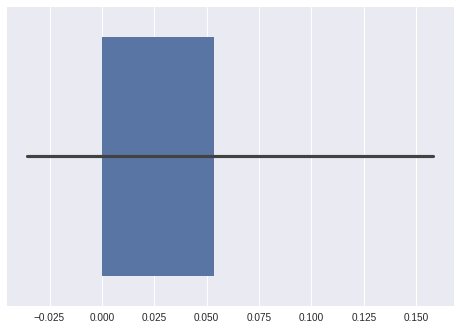

In [0]:

print(train_ind, trainval)


train_pairs, train_rel_list = create_test_pairs(run, trainval, test_docs, test_judgments)
test_pairs, test_rel_list = create_test_pairs(run, test, test_docs, test_judgments)
print('Training set', len(train_pairs))
print('Training set', len(train_rel_list))
print('Test set', len(test_pairs))
print('Test set', len(test_rel_list))
# print('Validation set', len(val_pairs))
# print('Validation set', len(val_rel_list))

print('# of unique train documents', len(set([v[1] for v in train_pairs])))
print('# of unique train topics', len(set([v[0] for v in train_pairs])))
# print('# of unique val documents', len(set([v[1] for v in val_pairs])))
# print('# of unique train topics', len(set([v[0] for v in val_pairs])))
print('# of unique test documents', len(set([v[1] for v in test_pairs])))
print('# of unique train topics', len(set([v[0] for v in test_pairs])))

X_train_abs, X_train_keywords, X_train_titles,  X_train_queries, train_rel_list = create_X(train_pairs, train_rel_list, queries, test_docs)
# X_val_abs, X_val_keywords, X_val_titles,  X_val_queries, val_rel_list = create_X(val_pairs, val_rel_list, queries, test_docs)
X_test_abs, X_test_keywords, X_test_titles, X_test_queries, test_rel_list = create_X(test_pairs, test_rel_list, queries, test_docs) 


train_features = np.hstack( [features_stream_abs(X_train_abs, X_train_queries),features_stream_keywords(X_train_keywords, X_train_queries), features_stream_title(X_train_titles, X_train_queries)])
# val_features = np.hstack( [features_stream_abs(X_val_abs, X_val_queries),features_stream_keywords(X_val_keywords, X_val_queries), features_stream_title(X_val_titles, X_val_queries)])
test_features = np.hstack([features_stream_abs(X_test_abs, X_test_queries), features_stream_keywords(X_test_keywords, X_test_queries), features_stream_title(X_test_titles, X_test_queries)])

scaler = StandardScaler()
print(scaler.fit(train_features))
StandardScaler(copy=True, with_mean=True, with_std=True)
train_features = scaler.transform(train_features)
# val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)  

feature_groups_intervals = [] 

subsets = [best_set]

feat_subsets = []
for a in subsets:
  feats = []
  for group in a:
    feats += featuremap[group]

  feat_subsets.append(feats)


print(feat_subsets)
rank_performance_list = []

for group in feat_subsets:
  print(group)
  train_features_subset = train_features[:, group]
#   val_features_subset = val_features[:, group]
  test_features_subset = test_features[:, group]
  print(group, train_features_subset.shape)
  preds, auc, coefs, clf = logistic_regression(train_features_subset, test_features_subset, train_rel_list, test_rel_list)
#   sns.barplot(coefs)
  logreglist = []
  for chunk in chunks(preds, topk):
    newrank = pd.DataFrame(pred2rank(chunk)).iloc[:, 1]
    logreglist.append(newrank)

  relevancelist = []
  ranklist = []
  for e, ohsu in enumerate(test):
    relevance = get_ranking(ohsu, run, test_judgments)  
    relevancelist.append(relevance)

    ranking = get_inv_rank(ohsu, run)
    ranklist.append(ranking)       

  microsoft_aps = []

  for (a, b) in zip(relevancelist, ranklist):
    ap = (average_precision_score(a,b))
    if pd.isna(ap):

      microsoft_aps.append(0)
    else:

      microsoft_aps.append(ap)

  logistic_aps = []
  for (a, b) in zip(relevancelist, logreglist):
    ap = (average_precision_score(a,b))
    if pd.isna(ap):    
      logistic_aps.append(0)
    else:    
      logistic_aps.append(ap)
  rank_performance_list.append(np.mean(logistic_aps))
  print("MAP Microsoft: ", np.mean(microsoft_aps))
  print("MAP Logistic Rerank: ", np.mean(logistic_aps))

results_df = pd.DataFrame()
results_df['Feature Group'] = list(subsets)
results_df['Rerank MAP'] = rank_performance_list
sorted_results = results_df.sort_values(by='Rerank MAP', ascending=False)
#   top10_fg_powerset = sorted_results['Feature Group']

print(sorted_results)
sorted_results.to_csv('drive/My Drive/Information Retrieval/results_powersets_text_normalization_20dec_test_set_fulltrainingdata.csv')

## Plot coefficients of best model

17 17


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


17

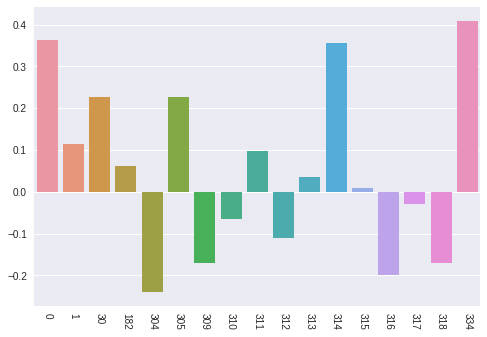

In [0]:
import matplotlib.pyplot as plt
print(len(feat_subsets[0]), len(coefs[0]))
best_feats = ['KW Query Term Coverage', 'KW Normalized QTC', 'KW Cosine', 'T Cosine','ABS Query Term Coverage', 'ABS Normalized QTC', 'ABS Partial TF Sum', 'ABS Partial TF Min',
              'ABS Partial TF Max', 'ABS Partial TF Mean', 'ABS Partial TF Variance', 'ABS Partial TF Sum Normalized', 'ABS Partial TF Min Normalized',
              'ABS Partial TF Max Normalized', 'ABS Partial TF Mean Normalized', 'ABS Partial TF Variance Normalized',  'ABS Cosine']
g = sns.barplot(best_feats, coefs[0])
plt.setp(g.get_xticklabels(), rotation=-90)
len(best_feats)

In [0]:
feat_subsets[0]

[334,
 30,
 0,
 1,
 182,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 304,
 305]

# RankSVM

In [16]:

train_pairs, train_rel_list = create_test_pairs(run, trainval, test_docs, test_judgments)
test_pairs, test_rel_list = create_test_pairs(run, test, test_docs, test_judgments)


print('# of unique train documents', len(set([v[1] for v in train_pairs])))
print('# of unique train topics', len(set([v[0] for v in train_pairs])))

print('# of unique test documents', len(set([v[1] for v in test_pairs])))
print('# of unique train topics', len(set([v[0] for v in test_pairs])))

X_train_abs, X_train_keywords, X_train_titles,  X_train_queries, train_rel_list = create_X(train_pairs, train_rel_list, queries, test_docs)

X_test_abs, X_test_keywords, X_test_titles, X_test_queries, test_rel_list = create_X(test_pairs, test_rel_list, queries, test_docs) 


train_features = np.hstack( [features_stream_abs(X_train_abs, X_train_queries),features_stream_keywords(X_train_keywords, X_train_queries), features_stream_title(X_train_titles, X_train_queries)])
test_features = np.hstack([features_stream_abs(X_test_abs, X_test_queries), features_stream_keywords(X_test_keywords, X_test_queries), features_stream_title(X_test_titles, X_test_queries)])

scaler = StandardScaler()
print(scaler.fit(train_features))
StandardScaler(copy=True, with_mean=True, with_std=True)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features) 

# of unique train documents 1409
# of unique train topics 50
# of unique test documents 390
# of unique train topics 13
Pairs:  1500
Rellist:  1500
Length
1500
1500
Pairs:  390
Rellist:  390
Length
390
390
0
250
500
750
1000
1250
0
250
500
750
1000
1250
0
250
500
750
1000
1250
0
250
0
250
0
250
StandardScaler(copy=True, with_mean=True, with_std=True)


In [0]:
# SUBSET features for RANKSVM
subs = np.sort([334,
 30,
 0,
 1,
 182,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 304,
 305])

train_features = train_features[:, subs]
test_features = test_features[:, subs]

## Create query, document and corresponding feature pairs for test and training set

In [0]:
# Relate features to documents
query_documents_train = {}
query_documents_test = {}
cnt = 0

for idx, topic in enumerate(run['Topic'][run['Topic'].isin(trainval)]):
    if topic not in query_documents_train.keys():
        query_documents_train[topic] = []
    uid = {run.iloc[idx, 2] : train_features[idx]}
    query_documents_train[topic].append(uid)

for idx, topic in enumerate(run['Topic'][run['Topic'].isin(test)]):
    if topic not in query_documents_test.keys():
        query_documents_test[topic] = []
    uid = {run.iloc[idx, 2] : test_features[idx]}
    query_documents_test[topic].append(uid)

## Get training pairs and train SVM

In [0]:
# RankedSVM
from sklearn import svm
import operator

def create_pairs(queries_doc_dict):
    '''
    Create pairs of documents.
    '''
    keys = queries_doc_dict.keys()
    query_pairs = {}
    class_pairs = {}
    for q in keys:
        classes = []
        query_documents = [list(x.keys())[0] for x in queries_doc_dict[q]]
        pairs = []
        for doc in query_documents:
            for doc2 in query_documents:
                if doc2 != doc:
                    pairs.append([doc, doc2])

                    first = list([x for x in query_documents 
                             if x in [doc, doc2]])[0]
                    classes.append(1 if doc == first else 0)
        class_pairs[q] = classes
        query_pairs[q] = pairs
    return query_pairs, class_pairs

query_pairs_train, query_train_classes = create_pairs(query_documents_train)

In [0]:
X_train, y_train = [], []


for key in query_pairs_train.keys():
    '''
    Concatenate features for documents so that we can train our SVM.
    '''
    query_dict = query_documents_train[key]
    for e, dp in enumerate(query_pairs_train[key]):
        feature = []
        #sanity
        res1 = [list(x.values())[0] for x in query_dict if list(x.keys()) == dp[0]][0]
        res2 = [list(x.values())[0] for x in query_dict if list(x.keys()) == dp[1]][0]
        feature = res1 - res2
        X_train.append(feature)
    y_train.extend(query_train_classes[key])

In [27]:
# Train normal SVM on query pairs and binary labels
model2 = svm.SVC(kernel='linear')#(C=0.01, kernel='linear')#, probability=True)#svm.SVC(kernel='linear')
model2.fit(X_train, y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
query_pairs_test, query_test_classes = create_pairs(query_documents_test)
X_test, y_test = [], []
for key in query_pairs_test.keys():
    '''
    Concatenate features for documents so that we can train our SVM.
    '''
    query_dict = query_documents_test[key]
    for e, dp in enumerate(query_pairs_test[key]):
        feature = []
        res = [list(x.values())[0] for x in query_dict if list(x.keys()) in dp]
        feature = np.concatenate((res[0], res[1]), axis=0)
        feature = res[0] - res[1]

        X_test.append(feature)
    y_test.extend(query_test_classes[key])
#print_evaluation_scores(y_test, model.predict(X_test))
# query_pairs_test

In [29]:
roc_auc_score(y_test, model2.predict(X_test)), roc_auc_score(y_train, model2.predict(X_train))

(0.5, 0.5420689655172414)

In [25]:


print_evaluation_scores(y_train, model2.predict(X_train))

Accuracy:  0.5420689655172414
F1-score 0.5436635205717951
Precision  0.5227919982114686


In [26]:
print_evaluation_scores(y_test, model2.predict(X_test))

Accuracy:  0.5
F1-score 0.5057250240363604
Precision  0.5


## Get query pairs for testing

## Determine ranking for test pairs by using pair wise ranking

In [0]:
def pair_wise_ranking(query_pairs, query_dict, model):
    '''
    Compare all query pairs.
    Input (doc1, doc2) if doc1 is higher than doc 2, return 1
    Input (doc1, doc3) if doc1 is lower than doc 3, return -1
    Sum all results for the documents, which gives the rank.
    ''' 
    results = {}

    for dp in query_pairs:
        if dp[0] not in results.keys():
            results[dp[0]] = 0

        # Get feature for documents.
        res1 = [list(x.values())[0] for x in query_dict if list(x.keys()) == dp[0]][0]
        res2 = [list(x.values())[0] for x in query_dict if list(x.keys()) == dp[1]][0]
        #feature = np.concatenate((res[0], res[1]), axis=0)
        feature = res1 - res2   
        #score = model.predict_proba([feature])[:,0][0]
        #print(score)
        #results[dp[0]] += score
        score = model.predict([feature])[0]
        if score == 1:
            # Signal that ranking is correct.
            results[dp[0]] += 1
        else:
            # Signal that ranking is incorrect.
            results[dp[0]] -= 1
    
    return list(results.items())


ranking_queries = {}
for query in list(query_pairs_test.keys()):
    ranking_queries[query] = pair_wise_ranking(query_pairs_test[query],
                                               query_documents_test[query], 
                                               model2)
    print(ranking_queries[query])
    print('Processed ranking for query {}, amount of docs for this query {}'.format(query, len(ranking_queries[query])))

[(88002743, -27), (88095668, 3), (88103805, -19), (88181296, -7), (88196514, 5), (88196515, -3), (88201371, -9), (88238703, 9), (88238705, 25), (88238706, 21), (88283372, -21), (89015550, 11), (89015552, 15), (89023354, 23), (89078872, 1), (89153654, -23), (89178991, 13), (89182887, -25), (89184080, 17), (89184093, 29), (89201699, -5), (89201700, 27), (89213723, -15), (89225293, -13), (89228983, -11), (89244867, 19), (89244872, -1), (89244873, -17), (89270656, 7), (89277954, -29)]
Processed ranking for query OHSU2, amount of docs for this query 30
[(88012687, -13), (88045917, -5), (88046825, 23), (88048250, 13), (88070865, 15), (88071146, 5), (88099036, 1), (88102808, -27), (88145328, -23), (88154613, -3), (88159008, 9), (88161153, 17), (88162311, -9), (88252600, 11), (88274205, -7), (88280216, 7), (89043526, -19), (89116245, 19), (89127813, -17), (89148176, -25), (89149259, -11), (89271792, -29), (89271810, 21), (89309709, 29), (89309717, 3), (89355395, 25), (90022649, -15), (90042765

In [0]:
newranklist[8]

In [0]:
svmlist = []
for key, values in ranking_queries.items():
  #print(key, len(values))
  #print(ranking_queries)
  vals = [k[1] for k in values]
  svmlist.append(pd.DataFrame(vals))

In [0]:
  ranks = run.loc[run['Topic'] == topic]
  ranks['inverted_rank'] = 1/ranks['rank']
  ranks = pd.merge(ranks, judgments, left_on=['Topic','ui'], right_on=['topic','uid'], how='left')
  ranks['relevance'] = ranks['relevance'].fillna(0)
  ranks['relevance'] = ranks['relevance'].apply(lambda x: 1.0 if (x == 2 or x == 1) else 0)
  return ranks['relevance']

def get_inv_rank(topic, run):

  ranks = run.loc[run['Topic'] == topic]
  ranks['inverted_rank'] = 1/ranks['rank']
  return ranks['inverted_rank']

relevancelist = []
ranklist = []
for e, ohsu in enumerate(test):
  relevance = get_ranking(ohsu, run, test_judgments)  
  relevancelist.append(relevance)
                
  ranking = get_inv_rank(ohsu, run)
  ranklist.append(ranking)       
   
microsoft_aps = []

for (a, b) in zip(relevancelist, ranklist):
  ap = (average_precision_score(a,b))
  if pd.isna(ap):
#     print(0)
    microsoft_aps.append(0)
  else:
#     print(ap)
    microsoft_aps.append(ap)
  

svm_aps = []
for (a, b) in zip(relevancelist, svmlist):
  ap = (average_precision_score(a,b))
  if pd.isna(ap):
#     print(0)
    svm_aps.append(0)
  else:
#     print(ap)
    svm_aps.append(ap)

  
print("MAP Microsoft: ", np.mean(microsoft_aps))
print("MAP SVM Rerank: ", np.mean(svm_aps))